In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from nst_utils import *

%matplotlib inline

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


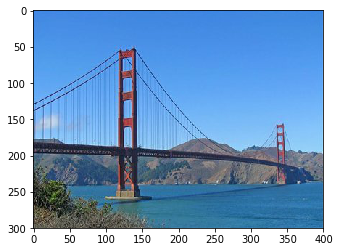

In [3]:
content_image = scipy.misc.imread("images/rsz_ggb.jpg")
imshow(content_image)

In [4]:
## Compute Content Cost - this function measures how different a_C and a_G are
def compute_content_cost(a_C, a_G):
    ##Retrieve Dimensions of a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    ##Reshape a_C and a_G
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    ##Compute Cost with tensorflow
    J_content = (1 /( 4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.pow(a_C_unrolled - a_G_unrolled, 2))
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1,4,4,3], mean=1, stddev=4)
    a_G = tf.random_normal([1,4,4,3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


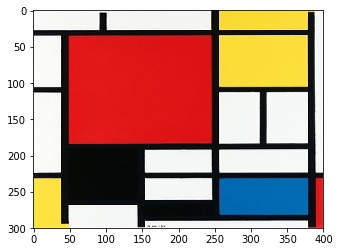

In [6]:
style_image = scipy.misc.imread("images/rsz_piet-mondrian-ohne-titel-3-works.jpg")
imshow(style_image)

In [7]:
## Gram Matrix - GM is used to compare how similar dot products are
## Gram matrix is essentially a cross product matrix multiplied by its transpose

def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    print("GA = " + str(GA.eval()))

GA = [[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


In [9]:
## Compute Style Layer Cost
## This function computes the style cost for a single layer

def compute_layer_style_cost(a_S, a_G):
    ## Retrieve dimensions
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    ## Reshape images to shape H*W, C
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    
    ## Get Gram Matrix of a_G and a_S
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = (1. / (4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS-GG), 2))
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)
]

In [12]:
## This one just calls style_layer_cost a number of times
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        J_style += coeff * J_style_layer
    
    return J_style

In [13]:
## Total Cost to Optimize
## A and B are hyperparams that control relative weighting
## Total cost is a linear combination of content cost and style cost

def total_cost(J_content, J_style, alpha=10, beta=40):
    
    J = alpha * J_content + beta * J_style
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [15]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

content_image = scipy.misc.imread("images/rsz_ggb.jpg")
content_image = reshape_and_normalize_image(content_image)

style_image = scipy.misc.imread("images/rsz_piet-mondrian-ohne-titel-3-works.jpg")
style_image = reshape_and_normalize_image(style_image)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


In [16]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x108c8ed90> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

In [17]:
## Assign content image to be the input of the model

model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
sess.run(model['input'].assign(content_image))
out = model['conv5_1']
a_S = sess.run(out)
a_G = out
J_content = compute_content_cost(a_S, a_G)

In [18]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)
J = total_cost(J_content, J_style, alpha=10, beta=50)

In [19]:
## Define Optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# Define train step
train_step = optimizer.minimize(J)


In [20]:
## this function initializes variables, assigns input image and runs train_step
def model_nn(sess, input_image, num_iterations=300):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
    
    for i in range (num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model["input"])
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration:"+str(i)+" : ")
            print("total cost="+str(Jt))
            print("content cost="+str(Jc))
            print("style_cost="+str(Js))
            
            save_image("output/"+str(i)+".png", generated_image)
        
    save_image("output/generated_image.jpg", generated_image)
    return generated_image


In [21]:
model_nn(sess, generated_image)

Iteration:0 : 
total cost=8.637e+10
content cost=72.9017
style_cost=1.7274e+09
Iteration:20 : 
total cost=3.4847e+10
content cost=115.2
style_cost=6.96939e+08
Iteration:40 : 
total cost=2.01472e+10
content cost=135.864
style_cost=4.02944e+08
Iteration:60 : 
total cost=1.43959e+10
content cost=155.169
style_cost=2.87918e+08
Iteration:80 : 
total cost=1.14985e+10
content cost=166.344
style_cost=2.2997e+08
Iteration:100 : 
total cost=9.67315e+09
content cost=173.237
style_cost=1.93463e+08
Iteration:120 : 
total cost=8.40036e+09
content cost=179.087
style_cost=1.68007e+08
Iteration:140 : 
total cost=7.44448e+09
content cost=183.691
style_cost=1.48889e+08
Iteration:160 : 
total cost=6.68577e+09
content cost=188.152
style_cost=1.33715e+08
Iteration:180 : 
total cost=6.07196e+09
content cost=192.576
style_cost=1.21439e+08
Iteration:200 : 
total cost=5.5596e+09
content cost=195.704
style_cost=1.11192e+08
Iteration:220 : 
total cost=5.11194e+09
content cost=198.437
style_cost=1.02239e+08
Iterat

array([[[[  1.02480114e+00,   7.23705139e+01,   2.29541702e+02],
         [  3.53058090e+01,   6.88336258e+01,   1.79702209e+02],
         [  6.02308350e+01,   1.07160378e+02,   2.07667831e+02],
         ..., 
         [  2.14727478e+01,   1.08707352e+02,   1.60170853e+02],
         [ -4.79519501e+01,   4.82568398e+01,   1.28798264e+02],
         [ -1.78267792e+02,  -7.22937164e+01,   6.97125015e+01]],

        [[ -3.79438438e+01,   1.20148201e+01,   1.28478348e+02],
         [ -2.91761227e+01,   9.39807320e+00,   9.69662323e+01],
         [  4.67779961e+01,   1.06653168e+02,   1.75861588e+02],
         ..., 
         [ -1.03815567e+02,  -5.98483505e+01,   1.03572853e+02],
         [ -1.24125542e+02,  -8.90245895e+01,   4.80297203e+01],
         [ -1.38167755e+02,  -6.61732559e+01,   4.26417427e+01]],

        [[  3.08353081e+01,   1.46512497e+02,   1.91264038e+02],
         [ -7.02693405e+01,  -5.36632881e+01,   3.79083519e+01],
         [ -6.72876587e+01,  -4.31769791e+01,  -8.265158